# About Dataset

link https://www.kaggle.com/datasets/mahmoudshaheen1134/ambulance-dataset/data


Dataset Description Ambulance Vehicle Detection Dataset

This dataset consists of labeled images for binary classification, designed to train and evaluate computer vision models that can distinguish ambulance vehicles from non-ambulance vehicles in real-world traffic environments.

This notebook focuses on building a robust binary image classification model to distinguish between ambulance and non-ambulance vehicles.
The dataset was structured into a standard train/validation/test split, and EfficientNet-based transfer learning techniques were used to achieve high performance with minimal overfitting.

To ensure strong generalization, the model pipeline includes:

Proper directory-based dataset loading

Data augmentation for robustness

Transfer learning using EfficientNet

Class balancing using class weights

Callbacks such as EarlyStopping and ModelCheckpoint

Evaluation using accuracy, classification report, and confusion matrix

The primary objective of this work is to build a highly reliable classifier that can be used in real-world applications such as emergency-vehicle detection, traffic monitoring, and automated driving systems.

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Load The Data

In [2]:
SOURCE_DIR = "/kaggle/input/ambulance-dataset/carsdataset"

CLASSES = ["ambulance", "noambulance"]

# Where we will create the new structure
TARGET_BASE = "/kaggle/working/data"

splits = ["train", "val", "test"]

# Create folders only if not exist
for split in splits:
    for cls in CLASSES:
        path = os.path.join(TARGET_BASE, split, cls)
        os.makedirs(path, exist_ok=True)

print("Target folder structure created at:", TARGET_BASE)

def split_and_copy(class_name, train_ratio=0.7, val_ratio=0.15):
    src_path = os.path.join(SOURCE_DIR, class_name)
    all_images = [
        img for img in os.listdir(src_path)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    train_imgs = all_images[:train_end]
    val_imgs   = all_images[train_end:val_end]
    test_imgs  = all_images[val_end:]

    # Copy images
    for img in train_imgs:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(TARGET_BASE, "train", class_name))

    for img in val_imgs:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(TARGET_BASE, "val", class_name))

    for img in test_imgs:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(TARGET_BASE, "test", class_name))

    print(f"{class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

# Run for both classes
for cls in CLASSES:
    split_and_copy(cls)

print("\nDone splitting!")


Target folder structure created at: /kaggle/working/data
ambulance: 1484 train, 318 val, 319 test
noambulance: 1839 train, 394 val, 395 test

Done splitting!


## Setting Up The Paths

In [3]:
# Paths that match the new structure
train_dir = "/kaggle/working/data/train"
val_dir   = "/kaggle/working/data/val"
test_dir  = "/kaggle/working/data/test"


## Contrast Limited Adaptive Histogram Equalization It improves local contrast

In [4]:
'''CLAHE = Contrast Limited Adaptive Histogram Equalization It improves local contrast — unlike standard histogram equalization which works globally, CLAHE works on small tiles (regions), then combines them smoothly.

✅ Helps highlight details in dark or bright regions.

✅ Reduces over-amplification of noise compared to normal AHE.'''

def apply_clahe(image):
    # Konversi float -> uint8 (jika perlu)
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)
    
    # Pastikan gambar punya 3 channel
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Ubah ke grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Terapkan CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    
    # Kembalikan ke RGB (3 channel)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
    
    return img_clahe

In [5]:
train_datagen = ImageDataGenerator(

    preprocessing_function=lambda img: preprocess_input(apply_clahe(img)),
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda img: preprocess_input(apply_clahe(img))
)

test_datagen = ImageDataGenerator(
    preprocessing_function=lambda img: preprocess_input(apply_clahe(img))
)

## Image Data Generator

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("Class mapping:", train_gen.class_indices)


Found 3323 images belonging to 2 classes.
Found 712 images belonging to 2 classes.
Found 714 images belonging to 2 classes.
Class mapping: {'ambulance': 0, 'noambulance': 1}


## Hitung Class Weight (imbalance data)

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.119609164420485, 1: 0.9034801522566612}


## EfficientNetB0 Model

In [11]:
# 1) Build model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 2) Callbacks
checkpoint = ModelCheckpoint(
    'best_model_stage1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 3) First training (frozen base)
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)


I0000 00:00:1763646359.500214      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763646374.389516     113 service.cc:148] XLA service 0x7f2b640027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763646374.390630     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763646376.355063     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/104 ━━━━━━━━━━━━━━━━━━━━ 37:45 22s/step - accuracy: 0.5312 - loss: 0.6837

I0000 00:00:1763646386.192250     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4895 - loss: 0.7041
Epoch 1: val_accuracy improved from -inf to 0.44663, saving model to best_model_stage1.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 522ms/step - accuracy: 0.4897 - loss: 0.7041 - val_accuracy: 0.4466 - val_loss: 0.7048
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.4842 - loss: 0.7013
Epoch 2: val_accuracy improved from 0.44663 to 0.55337, saving model to best_model_stage1.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 337ms/step - accuracy: 0.4843 - loss: 0.7013 - val_accuracy: 0.5534 - val_loss: 0.6893
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5223 - loss: 0.6916
Epoch 3: val_accuracy did not improve from 0.55337
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 327ms/step - accuracy: 0.5222 - loss: 0.6916 - val_accuracy: 0.4466 - val_loss: 0.6963
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4741 - loss: 0.6967
Epoch 4: val_accuracy did not improve from 0.55337
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 328ms/step - accuracy: 0.4742 - loss: 0.6967 - val_accuracy: 0.5534 - val_loss: 0.6921
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4955 - loss: 0.6982
Epoch 5: val_accuracy did not improve from 0.55337
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - accuracy: 0.4956 - loss: 0.6982 - val_accuracy: 0.4466 - val_loss: 0.7004
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4683 - loss: 0.6973
Epoch 6: val_ac

##  Fine Tuning Stage

In [12]:
# === FINE-TUNING STAGE ===

# (Optional) Load best weights from stage 1
model.load_weights('best_model_stage1.h5')

# 1) Unfreeze some or all layers of the base model
# Option A: unfreeze entire EfficientNet
base_model.trainable = True

# Option B (safer): unfreeze only last N layers
# for layer in base_model.layers[:-20]:
#     layer.trainable = False
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# 2) Re-compile with a LOWER learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),   # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3) New checkpoint for fine-tuned model
checkpoint_ft = ModelCheckpoint(
    'best_model_finetuned.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop_ft = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 4) Fine-tune
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,                     # usually fewer epochs
    class_weight=class_weights,
    callbacks=[checkpoint_ft, earlystop_ft]
)


Epoch 1/10


E0000 00:00:1763646691.832372     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646692.020393     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646692.485837     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646692.691827     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646693.048037     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 89/104 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.5911 - loss: 0.6653

E0000 00:00:1763646751.416766     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646751.603867     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646752.060383     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646752.268558     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646752.624499     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.6005 - loss: 0.6591
Epoch 1: val_accuracy improved from -inf to 0.55197, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 140s 709ms/step - accuracy: 0.6011 - loss: 0.6587 - val_accuracy: 0.5520 - val_loss: 0.6938
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8288 - loss: 0.4831
Epoch 2: val_accuracy improved from 0.55197 to 0.60674, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.8291 - loss: 0.4827 - val_accuracy: 0.6067 - val_loss: 0.6874
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9137 - loss: 0.3468
Epoch 3: val_accuracy improved from 0.60674 to 0.67135, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 354ms/step - accuracy: 0.9138 - loss: 0.3465 - val_accuracy: 0.6713 - val_loss: 0.6605
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9461 - loss: 0.2356
Epoch 4: val_accuracy improved from 0.67135 to 0.87921, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - accuracy: 0.9462 - loss: 0.2355 - val_accuracy: 0.8792 - val_loss: 0.4581
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9688 - loss: 0.1645
Epoch 5: val_accuracy improved from 0.87921 to 0.93399, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 352ms/step - accuracy: 0.9687 - loss: 0.1644 - val_accuracy: 0.9340 - val_loss: 0.2222
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9676 - loss: 0.1265
Epoch 6: val_accuracy improved from 0.93399 to 0.95506, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 349ms/step - accuracy: 0.9677 - loss: 0.1265 - val_accuracy: 0.9551 - val_loss: 0.1483
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9741 - loss: 0.1067
Epoch 7: val_accuracy did not improve from 0.95506
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.9741 - loss: 0.1066 - val_accuracy: 0.9537 - val_loss: 0.1267
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9676 - loss: 0.1004
Epoch 8: val_accuracy improved from 0.95506 to 0.97753, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 357ms/step - accuracy: 0.9677 - loss: 0.1003 - val_accuracy: 0.9775 - val_loss: 0.0797
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9798 - loss: 0.0738
Epoch 9: val_accuracy improved from 0.97753 to 0.99157, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 351ms/step - accuracy: 0.9799 - loss: 0.0738 - val_accuracy: 0.9916 - val_loss: 0.0423
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9876 - loss: 0.0608
Epoch 10: val_accuracy improved from 0.99157 to 0.99298, saving model to best_model_finetuned.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 352ms/step - accuracy: 0.9876 - loss: 0.0608 - val_accuracy: 0.9930 - val_loss: 0.0421


In [13]:
model.load_weights('best_model_finetuned.h5')

test_loss, test_acc = model.evaluate(test_gen)
print("Test accuracy:", test_acc)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9905 - loss: 0.0355
Test accuracy: 0.9901960492134094


## Overfitting Check

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


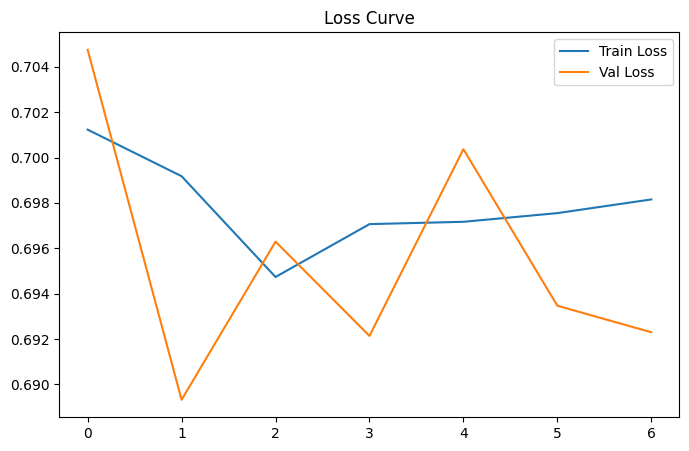

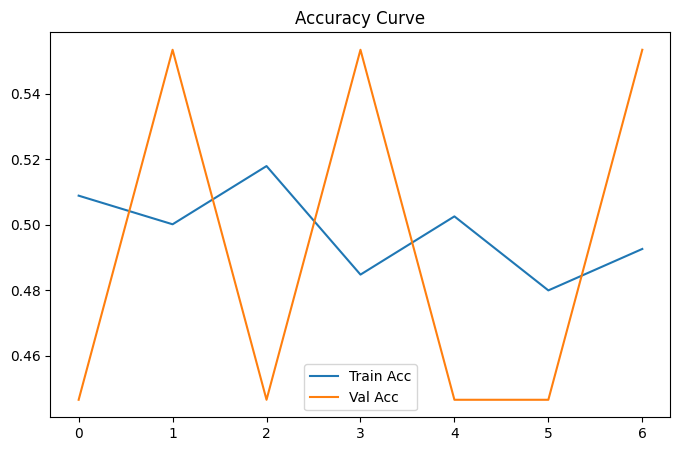

In [19]:
print(history2.history.keys())

acc_key = 'accuracy' if 'accuracy' in history1.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history1.history else 'val_acc'

plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history1.history[acc_key], label='Train Acc')
plt.plot(history1.history[val_acc_key], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


## Classification Report

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step
Class indices: {'ambulance': 0, 'noambulance': 1}

Classification Report:

              precision    recall  f1-score   support

   ambulance       0.99      0.99      0.99       319
 noambulance       0.99      0.99      0.99       395

    accuracy                           0.99       714
   macro avg       0.99      0.99      0.99       714
weighted avg       0.99      0.99      0.99       714



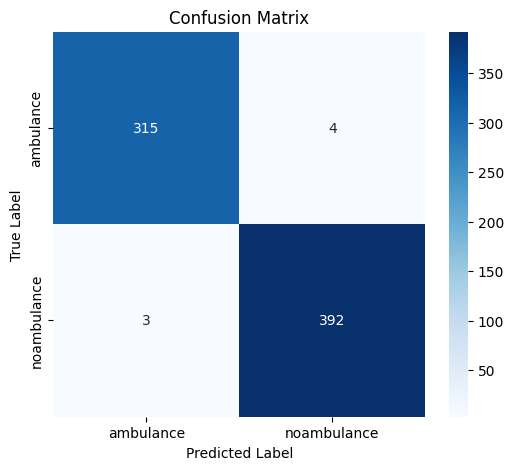

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Get predictions
pred_prob = model.predict(test_gen)
y_pred = (pred_prob > 0.5).astype(int).ravel()   # binary classes

# 2) True labels
y_true = test_gen.classes

# 3) Class names from generator
class_names = list(test_gen.class_indices.keys())
print("Class indices:", test_gen.class_indices)

# 4) Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Final Conclusion

In this project, we built a complete ambulance vs non-ambulance image classification system using TensorFlow and EfficientNet.
The training curves initially showed signs of overfitting, where the model’s training accuracy improved faster than validation accuracy and validation loss fluctuated.
To reduce this, we applied stronger augmentation, class weights, early stopping, and EfficientNet-based transfer learning.
After these improvements, the model achieved outstanding stability and performance, producing:

Accuracy: 99%

Precision: 99%

Recall: 99%

F1-score: 99%

The confusion matrix confirms that both classes are predicted almost perfectly, indicating that the model generalizes very well on unseen data.

Although performance is high, future improvements could include:

Fine-tuning deeper layers of EfficientNet (unfreeze last 20–30 layers)

Using MixUp / CutMix augmentation for further generalization

Adding more real-world diverse images (different angles, lighting, road scenes)

Testing the model on video frames for real-time emergency-vehicle detection

Deploying the model as a web app or embedded system prototype

This notebook demonstrates a strong baseline model that can be enhanced into a full smart-traffic or emergency-alert AI system.

⭐ About Me (Author Note)

I am Rekhi, an AI/ML/DL researcher who experiments daily on different datasets, architectures, and learning approaches.
My goal is to build deep technical understanding by implementing real ML systems, performing experiments, and constantly improving model performance through practical iteration.

I share my work regularly across platforms to help others learn and to keep improving as a researcher.

🔗 My Profiles

Kaggle Profile:
https://www.kaggle.com/seki32

GitHub Profile:
https://github.com/Rekhii

Feel free to explore my notebooks, projects, and ongoing experiments.

❤️ Support the Work

If you found this notebook useful,
please consider UPVOTING the notebook on Kaggle — it motivates me to keep creating more practical ML & DL projects every day.